In [1]:
from datetime import datetime, date, timedelta
import json
import uuid
from enum import Enum
import random

# 3rd party modules
import boto3
import pandas as pd

# Custom modules
from ModelRun import ModelRun

from ModelClasses import ModelTypes, EpiParams, Intervention, Result, ModelReport

from checkPlots import prep_plot

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
s3 = boto3.resource("s3")

In [4]:
state_name = "Texas"

content_object = s3.Object("nyt-covid-caseload", f"{state_name}.json")
file_content = content_object.get()["Body"].read().decode("utf-8")
state_timeseries = json.loads(file_content)

In [5]:
state_timeseries

{'2020-02-12': {'state': 'Texas', 'fips': '48', 'cases': '1', 'deaths': '0'},
 '2020-02-13': {'state': 'Texas', 'fips': '48', 'cases': '2', 'deaths': '0'},
 '2020-02-14': {'state': 'Texas', 'fips': '48', 'cases': '2', 'deaths': '0'},
 '2020-02-15': {'state': 'Texas', 'fips': '48', 'cases': '2', 'deaths': '0'},
 '2020-02-16': {'state': 'Texas', 'fips': '48', 'cases': '2', 'deaths': '0'},
 '2020-02-17': {'state': 'Texas', 'fips': '48', 'cases': '2', 'deaths': '0'},
 '2020-02-18': {'state': 'Texas', 'fips': '48', 'cases': '2', 'deaths': '0'},
 '2020-02-19': {'state': 'Texas', 'fips': '48', 'cases': '2', 'deaths': '0'},
 '2020-02-20': {'state': 'Texas', 'fips': '48', 'cases': '2', 'deaths': '0'},
 '2020-02-21': {'state': 'Texas', 'fips': '48', 'cases': '4', 'deaths': '0'},
 '2020-02-22': {'state': 'Texas', 'fips': '48', 'cases': '4', 'deaths': '0'},
 '2020-02-23': {'state': 'Texas', 'fips': '48', 'cases': '4', 'deaths': '0'},
 '2020-02-24': {'state': 'Texas', 'fips': '48', 'cases': '10', '

In [6]:
state_timeseries = {
    '2020-11-19': {'state': 'Munich', 'fips': '123', 'cases': '5', 'deaths': '0'},
    '2020-11-20': {'state': 'Munich', 'fips': '123', 'cases': '10', 'deaths': '0'},
    '2020-11-21': {'state': 'Munich', 'fips': '123', 'cases': '15', 'deaths': '0'},
    '2020-11-22': {'state': 'Munich', 'fips': '123', 'cases': '30', 'deaths': '0'},
    '2020-11-23': {'state': 'Munich', 'fips': '123', 'cases': '50', 'deaths': '0'},
    '2020-11-24': {'state': 'Munich', 'fips': '123', 'cases': '75', 'deaths': '0'},
}

* pick 5-15 cities - random number of cases between X and Y seeded
* once community spread is reached, rest of country is seeded
* X weeks after first community spread, ROW is seeded

* Detection?
* Stringency index from https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker#data to drive directional change in beta mild/asymp after detection?

In [7]:
cities = pd.read_csv('largest_cities.csv')
countries = pd.read_csv('country_pops.csv')

In [8]:
countries['country'] = countries['country'].str.strip()
cities['country_x'] = cities['Country'].str.strip()

In [9]:
cities = pd.merge(cities, countries, how='left', left_on='country_x', right_on='country')

In [10]:
cities.head()

,City,Country,UN 2018 Population estimates,City Proper definition,City proper population,City Proper area,Metro area population,Metro area area,Urban area population,Urban area area,country_x,rank,country,population
0,Tokyo,Japan,"37,400,068",Metropolis prefecture,"13,515,271[14]","2,191[14]","37,274,000[15]","13,452[15]","37,977,000","8,230[e]",Japan,11,Japan,"126,476,461"
1,Delhi,India,"28,514,000",National capital territory,"16,753,235[16]","1,484","29,000,000[17]","3,483[17]","29,617,000","2,232[f]",India,2,India,"1,380,004,385"
2,Shanghai,China,"25,582,000",Municipality,"24,183,000[18]","6,341",NaN,NaN,"22,120,000","4,068[g]",China,1,China,"1,439,323,776"
3,São Paulo,Brazil,"21,650,000",Municipality,"12,252,023[19]","1,521","21,734,682[20]","7,947","22,046,000","3,116[h]",Brazil,6,Brazil,"212,559,417"
4,Mexico City,Mexico,"21,581,000",City-state,"8,918,653[21]","1,485","20,892,724[22]","7,854","20,996,000","2,386",Mexico,10,Mexico,"128,932,753"


In [11]:
cities['proper_pop'] = cities['City proper population'].str.split("[").str[0].str.replace(",", "")
cities['proper_area'] = cities['City Proper area'].str.split("[").str[0].str.replace(",", "")
cities['metro_pop'] = cities['Metro area population'].str.split("[").str[0].str.replace(",", "")
cities['metro_area'] = cities['Metro area area'].str.split("[").str[0].str.replace(",", "")
cities['urban_pop'] = cities['Urban area population'].str.split("[").str[0].str.replace(",", "")
cities['urban_area'] = cities['Urban area area'].str.split("[").str[0].str.replace(",", "")

cities['urban_pop'] =  pd.to_numeric(cities['urban_pop'])
cities['urban_area'] = pd.to_numeric(cities['urban_area'])

cities['population'] = pd.to_numeric(cities['population'].str.replace(",", ""))

In [12]:
cities.rename(columns={'UN 2018 Population estimates': 'un_2018_pop', 'City': 'city', 'population': 'country_pop'}, inplace=True)

cities = cities.loc[:, ['city', 'country', 'country_pop', 'un_2018_pop', 'proper_pop', 'proper_area', 'metro_pop', 
                        'metro_area', 'urban_pop', 'urban_area']]

In [13]:
cities['rest_of_country'] = cities['country_pop'] - cities['urban_pop']

In [14]:
cities.shape

(81, 11)

In [15]:
#cities.loc[:, ['city', 'country', 'urban_pop', 'urban_area', 'rest_of_country']].set_index('city').to_json('population_largest_cities.json', orient='index')

In [16]:
num_cities = 5

infected_cities = pd.DataFrame(columns=cities.columns)

print(infected_cities.head())

while infected_cities.shape[0] < num_cities:
    infected_cities = cities.sample(n=num_cities)
    print(f'before: {infected_cities.shape[0]}')
    infected_cities.drop_duplicates(subset='country', inplace=True)
    print(f'after: {infected_cities.shape[0]}')
    
print(infected_cities.shape[0])

Empty DataFrame
Columns: [city, country, country_pop, un_2018_pop, proper_pop, proper_area, metro_pop, metro_area, urban_pop, urban_area, rest_of_country]
Index: []
before: 5
after: 4
before: 5
after: 5
5


In [17]:
infected_cities.to_csv('5_infected_cities.csv', index=False)

In [82]:
flu_dict = {
    'presymptomatic_period': 2,
    'duration_mild_infections': 4,
    'duration_asymp_infections': 4,
    'hospital_time_recovery': 11,
    'icu_time_death': 8,
    'beta_asymp': 0.4,
    'beta_mild': 0.4,
    'beta_hospitalized': 0.1,
    'beta_icu': 0.1,
    'percent_asymp': 0.33,
    'hospitalization_rate': 0.3,
    'hospitalized_cases_requiring_icu_care': 0.7,
    'death_rate_for_critical': 0.75,
}

pox_dict = {
    'presymptomatic_period': 6,
    'duration_mild_infections': 6,
    'duration_asymp_infections': 6,
    'hospital_time_recovery': 11,
    'icu_time_death': 8,
    'beta_asymp': 0.94,
    'beta_mild': 0.94,
    'beta_hospitalized': 0.1,
    'beta_icu': 0.1,
    'percent_asymp': 0,
    'hospitalization_rate': 0.25,
    'hospitalized_cases_requiring_icu_care': 0.5,
    'death_rate_for_critical': 0.8,
}

covid_15_dict = {
    'presymptomatic_period': 6,
    'duration_mild_infections': 6,
    'duration_asymp_infections': 6,
    'hospital_time_recovery': 11,
    'icu_time_death': 8,
    'beta_asymp': 0.28,
    'beta_mild': 0.28,
    'beta_hospitalized': 0.1,
    'beta_icu': 0.1,
    'percent_asymp': 0.3,
    'hospitalization_rate': 0.1,
    'hospitalized_cases_requiring_icu_care': 0.25,
    'death_rate_for_critical': 0.4,
}

disease_params = pox_dict
#disease_params = flu_dict
#disease_params = covid_15_dict

In [81]:
city = 'Arnica'
run_type = 'city'
cases = 100

city_timeseries = {
    '2020-11-26': {'state': city, 'fips': '123', 
                   'cases': cases, 
                   'deaths': 0, 
                   'estimated_recovered': 0,
                   'active': cases,
                   'estimated_hospitalized': 0,
                   'estimated_infected': 0, 
                  },
}

d = run_model_with_params(city, 'city', city_timeseries, disease_params)
    
print(d['R effective'].max())
print(d['R effective'].min())

1.8040000000000003
1.8040000000000003


In [26]:
cities.loc[32, :]

city                  Bangkok
country              Thailand
country_pop          69799978
un_2018_pop        10,156,000
proper_pop            5782000
proper_area              1569
metro_pop            16255900
metro_area               7762
urban_pop          1.7066e+07
urban_area               3199
rest_of_country    5.2734e+07
Name: 32, dtype: object

In [27]:
num_cities = 5

infected_cities = pd.DataFrame(columns=cities.columns)

print(infected_cities.head())

while infected_cities.shape[0] < num_cities:
    infected_cities = cities.sample(n=num_cities)
    print(f'before: {infected_cities.shape[0]}')
    infected_cities.drop_duplicates(subset='country', inplace=True)
    print(f'after: {infected_cities.shape[0]}')
    
print(infected_cities.shape[0])

Empty DataFrame
Columns: [city, country, country_pop, un_2018_pop, proper_pop, proper_area, metro_pop, metro_area, urban_pop, urban_area, rest_of_country]
Index: []
before: 5
after: 3
before: 5
after: 4
before: 5
after: 5
5


In [28]:
world_pop = 7829017798
row = world_pop - infected_cities['country_pop'].sum()

In [29]:
def run_model_with_params(city, run_type, timeseries, disease_params):
    
    modelrun = ModelRun(city,  run_type)
    modelrun.get_data(timeseries)
    modelrun.set_epi_model("asymp")

    for param_name, param_value in disease_params.items():
        setattr(modelrun, param_name, param_value)

    modelrun.epi_run.generate_epi_params()
    params = modelrun.epi_run.EpiParameters

    modelrun.run()
    display = modelrun.epi_run.display_df.copy()
    display["cum_cases"] = display["infected"].cumsum()

    display["pct_infected"] = display["cum_cases"] / modelrun.population
    
    return display
    
def run_city_country(city):

    cases = random.randint(5, 35)

    city_timeseries = {
        '2020-11-26': {'state': city, 'fips': '123', 
                       'cases': cases, 
                       'deaths': 0, 
                       'estimated_recovered': 0,
                       'active': cases,
                       'estimated_hospitalized': 0,
                       'estimated_infected': 0, 
                      },
    }
 



    city_df = run_model_with_params(city, 'city', city_timeseries, disease_params)
    
    country_outbreak_threshold = 10 / 100000

    country_outbreak_date = city_df.loc[(city_df.pct_infected >= country_outbreak_threshold), 'date'].min()

    country_outbreak_date_str = country_outbreak_date.strftime("%Y-%m-%d")
    
    country_cases = random.randint(50, 500)
    
    country_timeseries = {
        country_outbreak_date_str: {'state': city, 'fips': '123',
                                    'cases': country_cases,
                                    'deaths': '0',
                                    'estimated_recovered': 0,
                                    'active': country_cases,
                                    'estimated_hospitalized': 0,
                                    'estimated_infected': 0, 
                                    },
    }
    
    
    country_df = run_model_with_params(city, 'country', country_timeseries, disease_params)

    return {'city': city_df, 'country': country_df}

In [85]:
city = 'Arnica'
run_type = 'city'
cases = random.randint(100, 300)

city_timeseries = {
    '2021-2-19': {'state': city, 'fips': '123', 
                   'cases': cases, 
                   'deaths': 0, 
                   'estimated_recovered': 0,
                   'active': cases,
                   'estimated_hospitalized': 0,
                   'estimated_infected': 0, 
                  },
}

#d = run_model_with_params(city, 'city', city_timeseries, disease_params)
    
#print(d['R effective'].max())
#print(d['R effective'].min())


modelrun = ModelRun(city,  run_type)
modelrun.get_data(city_timeseries)
modelrun.set_epi_model("asymp")

for param_name, param_value in disease_params.items():
    setattr(modelrun, param_name, param_value)

modelrun.epi_run.generate_epi_params()
params = modelrun.epi_run.EpiParameters

modelrun.run()
display = modelrun.epi_run.display_df.copy()
display["cum_cases"] = display["infected"].cumsum()

display["pct_infected"] = display["cum_cases"] / modelrun.population

KeyError: 'Arnica'

In [84]:
modelrun.population

1000000.0

In [31]:
print(modelrun.percent_asymp)
print(modelrun.hospitalization_rate)
print(modelrun.hospitalized_cases_requiring_icu_care)
print(modelrun.death_rate_for_critical)

print((1 - modelrun.percent_asymp) * modelrun.hospitalization_rate * modelrun.hospitalized_cases_requiring_icu_care * modelrun.death_rate_for_critical)

print(modelrun.case_fatality_rate)

0
0.25
0.5
0.8
0.1
0.1


In [32]:
display['dead'].max()

99747.93078753569

first case
2020-11-26 00:00:00
peak in hospitalizations
2021-01-15T00:00:00.000000000
81,118.25965118762
peak in icu
2021-01-23T00:00:00.000000000
25,369.401853200183
deaths
99,747.93078753569
interventions: None


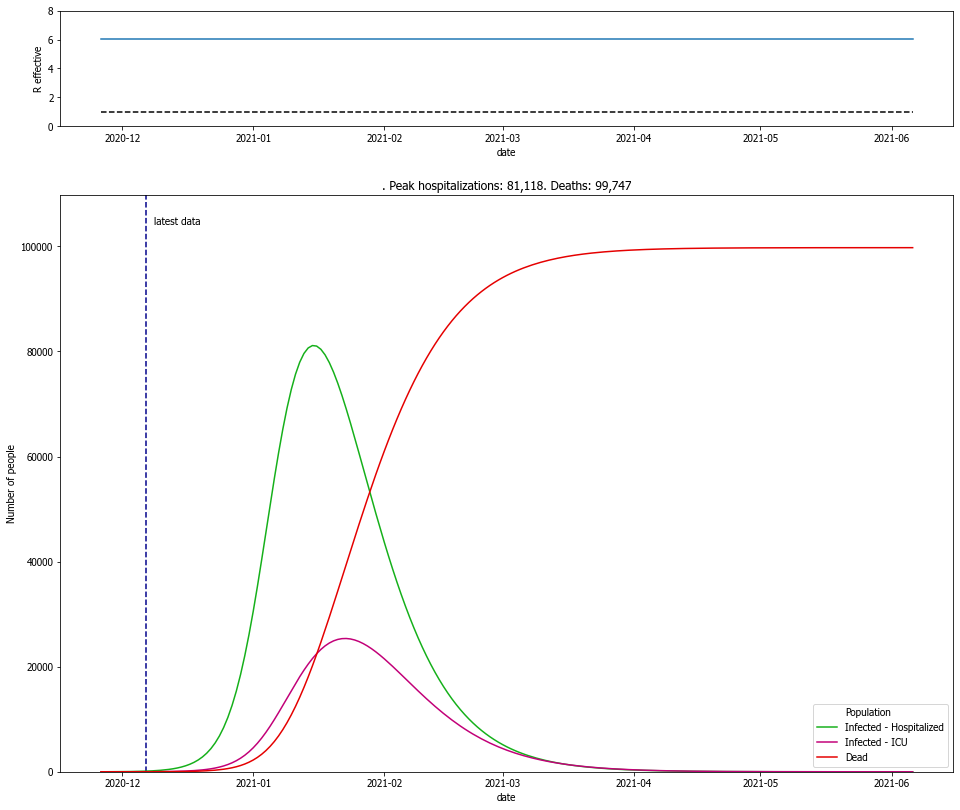

In [33]:
cols = ["infected_b", "infected_c", "dead", "R effective"]
prep_plot(display, cols, filename='flu_r=2.svg')

In [34]:
display['week'] = display['date'].dt.strftime('%Y-w%U')

In [35]:
display.head()

,date,exposed,infected_a,infected_b,infected_c,recovered,dead,asymp,source,R effective,infected,pct_change,doubling_time,cum_cases,pct_infected,week
0,2020-11-26,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,actuals,6.015,100.000000,NaN,NaN,100.000000,0.000100,2020-w47
0,2020-11-26,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,30.000000,base run,6.015,130.000000,NaN,NaN,230.000000,0.000230,2020-w47
1,2020-11-27,198.204390,107.896931,4.092795,0.089395,16.456392,0.003017,26.474907,base run,6.015,138.554028,NaN,NaN,368.554028,0.000369,2020-w47
2,2020-11-28,291.830718,129.122106,8.423717,0.346466,34.543353,0.023440,23.364023,base run,6.015,161.256313,NaN,NaN,529.810341,0.000530,2020-w47
3,2020-11-29,392.553790,161.893600,13.459496,0.772278,55.866991,0.077915,20.618678,base run,6.015,196.744052,NaN,NaN,726.554393,0.000727,2020-w48


In [36]:
display['date'].min()

Timestamp('2020-11-26 00:00:00')

In [38]:
display.loc[(display['date'] == '2020-12-21'), :]

,date,exposed,infected_a,infected_b,infected_c,recovered,dead,asymp,source,R effective,infected,pct_change,doubling_time,cum_cases,pct_infected,week
25,2020-12-21,61000.597108,26625.933221,3540.770074,457.158779,15598.62951,194.16955,1.318108,base run,6.015,30625.180181,0.250612,2.765813,152169.517008,0.15217,2020-w51


In [144]:
flu_weekly = display.groupby('week').max().reset_index()
flu_weekly['Hospitalized'] = flu_weekly['infected_b'] + flu_weekly['infected_c']
flu_weekly.head()

,week,date,exposed,infected_a,infected_b,infected_c,recovered,dead,asymp,source,R effective,infected,pct_change,doubling_time,cum_cases,pct_infected,Hospitalized
0,2020-w47,2020-11-28,291.830718,129.122106,8.423717,0.346466,34.543353,0.023440,30.000000,base run,6.015,161.256313,NaN,NaN,529.810341,0.000530,8.770184
1,2020-w48,2020-12-05,1666.474942,689.586938,82.797428,8.948065,352.659738,2.374508,20.618678,base run,6.015,791.072005,0.270425,3.572545,3583.034527,0.003583,91.745493
2,2020-w49,2020-12-12,8374.378297,3515.789647,450.639540,55.790110,1955.367467,20.775349,8.595144,base run,6.015,4026.279355,0.272080,2.645508,19209.161564,0.019209,506.429650
3,2020-w50,2020-12-19,40039.490294,17202.014589,2260.298489,289.426330,9921.927397,120.748901,3.582989,base run,6.015,19753.431893,0.261037,2.722366,96913.236313,0.096913,2549.724819
4,2020-w51,2020-12-26,153874.302268,73098.221748,10343.843468,1384.815387,46287.989901,614.828591,1.493612,base run,6.015,84827.586136,0.252816,3.018147,449270.263339,0.449270,11728.658855


In [145]:
flu_weekly.rename(columns = {
    'infected': 'Current cases',
    'cum_cases': 'Total cases',
    'dead': 'Dead',
    'week': 'Week',
}, inplace=True)

output_cols = ['Week', 'Total cases', 'Current cases', 'Hospitalized', 'Dead',]

flu_weekly = flu_weekly.loc[:, output_cols]

In [146]:
flu_weekly.to_csv('pox_weekly_summary-20201204.csv', index=False)

In [41]:
print(0.67 * 0.3 * 0.7 * 0.75)
print(0.3 * 0.5 * 0.8)

print(0.25 * 0.5 * 0.8)

0.105525
0.12
0.1
